In [16]:
import os
import cv2

# List of classes to consider
classes_to_consider = ["Car", "Van", "Truck"]

# Directory containing the .txt files
txt_files_directory = "project/data_object/labels/train"
image_files_directory = "project/data_object/images/train"

# Directory to save the filtered files
filtered_files_directory = "project/data_object/labels/preprocess"

kitti_class_mapping = {
    'Car': 0,
    'Van': 1,
    'Truck': 2,
}

def convert_bbox_to_yolo_format(filtered_lines, image_width, image_height):
    parts = filtered_lines.split()
    label = kitti_class_mapping[parts[0]]
    bbox = list(map(float, parts[4:8]))
    left, top, right, bottom = map(int, bbox)
    x_center = (left + right) / (2.0 * image_width)
    y_center = (top + bottom) / (2.0 * image_height)
    width = (right - left) / image_width
    height = (bottom - top) / image_height
    return label, x_center, y_center, width, height

# Loop through each .txt file
for txt_file in os.listdir(txt_files_directory):
    if txt_file.endswith(".txt"):
        with open(os.path.join(txt_files_directory, txt_file), 'r') as file:
            lines = file.readlines()
            # Filter lines based on classes_to_consider
            filtered_lines = [line.strip() for line in lines if line.split()[0] in classes_to_consider]

            # Save filtered lines to new file
            filtered_file_path = os.path.join(filtered_files_directory, f"{txt_file}")
            with open(filtered_file_path, 'w') as filtered_file:
                for line in filtered_lines:
                    filtered_file.write(line + '\n')
            print(f"Filtered data saved to {filtered_file_path}")
            
            # Load the corresponding image to get its dimensions
            image_name = os.path.splitext(txt_file)[0] + ".png"  # Assuming images are PNG format
            image_path = os.path.join(image_files_directory, image_name)
            image = cv2.imread(image_path)
            image_height, image_width, _ = image.shape

            # Convert bounding box coordinates to YOLO format and save to the same file, replacing existing content
            with open(filtered_file_path, 'w') as out_file:
                for line in filtered_lines:
                    label, x_center, y_center, width, height = convert_bbox_to_yolo_format(line, image_width, image_height)
                    out_file.write(f"{label} {x_center} {y_center} {width} {height}\n")



Filtered data saved to project/data_object/labels/preprocess\000000.txt
Filtered data saved to project/data_object/labels/preprocess\000001.txt
Filtered data saved to project/data_object/labels/preprocess\000002.txt
Filtered data saved to project/data_object/labels/preprocess\000003.txt
Filtered data saved to project/data_object/labels/preprocess\000004.txt
Filtered data saved to project/data_object/labels/preprocess\000005.txt


In [18]:
import os
import shutil
import random

# Define paths
image_dir = 'project/data_object/images/data'
bbox_dir = 'project/data_object/labels/preprocess'

train_image_dir = 'project/data_object/images/train'
train_bbox_dir = 'project/data_object/labels/train'

val_image_dir = 'project/data_object/images/val'
val_bbox_dir = 'project/data_object/labels/val'

test_image_dir = 'project/data_object/images/test'
test_bbox_dir = 'project/data_object/labels/test'

# Define the ratio for splitting
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create directories if they don't exist
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_bbox_dir, exist_ok=True)

os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_bbox_dir, exist_ok=True)

os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_bbox_dir, exist_ok=True)

# List all files in the image directory
image_files = os.listdir(image_dir)
# Shuffle the files randomly
random.shuffle(image_files)

# Split files into train, validation, and test sets
num_files = len(image_files)
num_train = int(num_files * train_ratio)
num_val = int(num_files * val_ratio)
num_test = num_files - num_train - num_val

train_image_files = image_files[:num_train]
val_image_files = image_files[num_train:num_train + num_val]
test_image_files = image_files[num_train + num_val:]

# Move image files to respective directories
for file in train_image_files:
    src = os.path.join(image_dir, file)
    dst = os.path.join(train_image_dir, file)
    shutil.copyfile(src, dst)

for file in val_image_files:
    src = os.path.join(image_dir, file)
    dst = os.path.join(val_image_dir, file)
    shutil.copyfile(src, dst)

for file in test_image_files:
    src = os.path.join(image_dir, file)
    dst = os.path.join(test_image_dir, file)
    shutil.copyfile(src, dst)

# Move corresponding bounding box files
for file in train_image_files:
    src = os.path.join(bbox_dir, file[:-4] + '.txt')  # Assuming bbox file has same name as image with '.txt' extension
    dst = os.path.join(train_bbox_dir, file[:-4] + '.txt')
    shutil.copyfile(src, dst)

for file in val_image_files:
    src = os.path.join(bbox_dir, file[:-4] + '.txt')
    dst = os.path.join(val_bbox_dir, file[:-4] + '.txt')
    shutil.copyfile(src, dst)

for file in test_image_files:
    src = os.path.join(bbox_dir, file[:-4] + '.txt')
    dst = os.path.join(test_bbox_dir, file[:-4] + '.txt')
    shutil.copyfile(src, dst)

print("Data splitting complete.")


Data splitting complete.


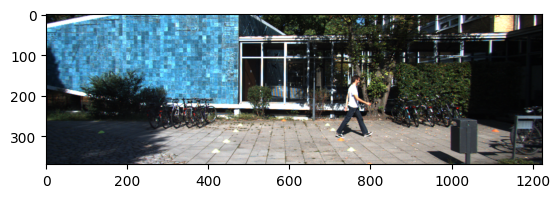

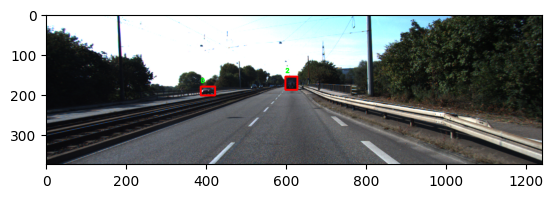

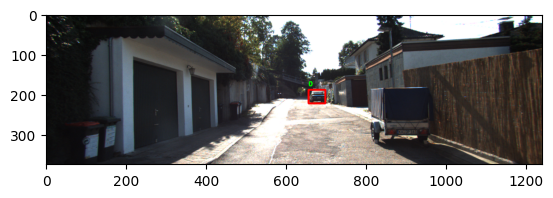

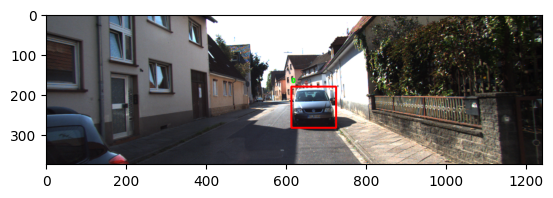

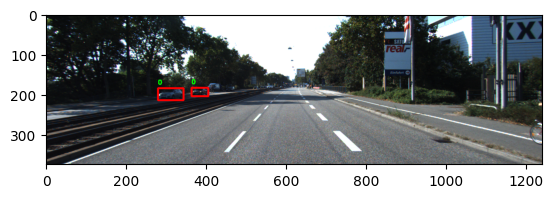

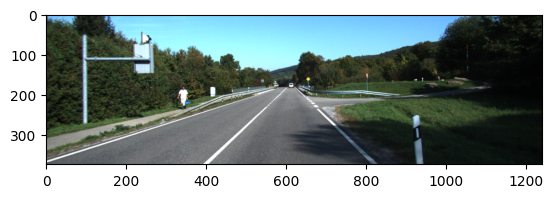

In [17]:
#This is the visualized the bounded box onto the images. This convers Yolo format to bounded box format 


import os
import cv2
import matplotlib.pyplot as plt

# Function to parse label lines
def parse_label(line):
    parts = line.split()
    label = parts[0]
    bbox = list(map(float, parts[1:5]))
    return label, bbox

# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

# Function to draw bounding boxes on the image
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
        cv2.putText(image, labels[box_num], (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

# Path to folders
image_folder = "project/data_object/images/training"
label_folder = "project/data_object/labels/preprocess"

# Iterate through images and corresponding labels
for image_name in os.listdir(image_folder):
    if image_name.endswith('.jpg') or image_name.endswith('.png'):
        image_path = os.path.join(image_folder, image_name)
        label_path = os.path.join(label_folder, os.path.splitext(image_name)[0] + '.txt')

        # Read image
        image = cv2.imread(image_path)

        # Parse label file
        labels = []
        bboxes = []
        with open(label_path, 'r') as f:
            for line in f:
                label, bbox = parse_label(line)
                labels.append(label)
                bboxes.append(bbox)

        # Draw bounding boxes on the image
        image_with_boxes = plot_box(image, bboxes, labels)

        # Display the image
        plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
        plt.show()
